In [1]:
import sys
sys.version

'3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]'

# Chapter 9 - Hierarchical Models

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import cm  # color map
import seaborn as sns
sns.set()

from matplotlib import gridspec

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
import torch
import torch as th

In [6]:
%load_ext watermark
%watermark -p pyro,arviz,scipy,numpy,pandas,torch

pyro  : 1.6.0
arviz : 0.11.2
scipy : 1.6.1
numpy : 1.20.1
pandas: 1.2.3
torch : 1.8.0



## Chapter 9.1 A Single Coin from a Single Mint

In [7]:
# observation: three Heads and 
y = np.zeros(12); 
y[:9] = 1  # Heads
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

### Posterior via grid-approximation

- Prior: 
    $$
        w \sim Beta(Aw, Bw) \\
        K = 100 \\
        p(\theta, \omega) = Beta(\theta|a(\omega), b(\omega)) Beta(\omega|A_\omega, B_\omega)
    $$
    - Domain of beta() is approximated with grid
- Likelihood:
    $$
        y_i \sim Bernoulli(\theta) \\
        p(y_i | \theta) = \theta^{y_i} (1 - \theta)^{1-y_i}
    $$
- Posterior:
    $$
        p(\theta, \omega| Y) \approx  p(\theta|a, b) p(\omega|A_w, B_w) \prod_{i=1}^n p(y_i|\theta) \\
        = p(\theta, \omega) \prod_{i=1}^n p(y_i|\theta) 
    $$

* The probability densities are all approximated as mass functions at the grid points.

In [8]:
grid = np.linspace(0, 1, 100)

#### Prior Distributioins

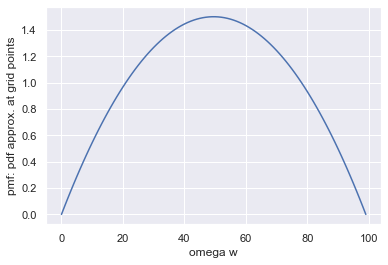

In [9]:
# hyper-prior: prior of prior
Aw, Bw = 2, 2
pdf_w = stats.beta(a=Aw, b=Bw).pdf(grid)

# hyper-prior for K, chosen as a constant 
K = 100

# plot
plt.xlabel('omega w')
plt.ylabel('pmf: pdf approx. at grid points')
plt.plot(pdf_w);

Prior: $\theta$ is determined as a sample from $p(\omega)$

In [10]:
# p(th, w) = p(th|w)p(w)
# p(th|w) = beta(w(K-2)+1, (1-w)(K-2)+1)
pdf_t_given_w = []  # conditionals; arrary of p(th|w) at w's
pdf_tw = []  # joint pdf p(th, w) = p(th|w) * p(w)
for iw, w in enumerate(grid):
    a, b = w*(K-2)+1, (1-w)*(K-2)+1  # (a,b) is determined at (w, K) 
    pdf_t_given_w_at_w = stats.beta(a,b).pdf(grid)
    
    pdf_t_given_w.append(pdf_t_given_w_at_w)
    pdf_tw.append(pdf_t_given_w_at_w * pdf_w[iw])
#
pdf_t_given_w = np.array(pdf_t_given_w) # array of conditionals
#
pdf_tw = np.array(pdf_tw)  # joint prior
pdf_tw /= pdf_tw.sum()

prior = pdf_tw
print(f'# Prior Probability Mass Distribution: {prior.shape}')

# Prior Probability Mass Distribution: (100, 100)


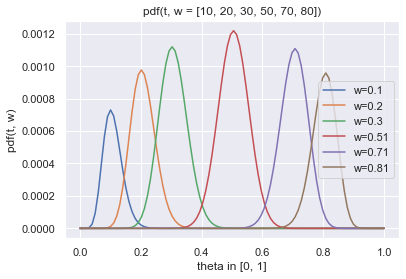

In [11]:
idxs = [10, 20, 30, 50, 70, 80]
for i in idxs:
    plt.plot(grid, pdf_tw[i], label=f'w={grid[i]:.2}')
plt.title(f'pdf(t, w = {idxs})')
plt.xlabel('theta in [0, 1]')
plt.ylabel('pdf(t, w)')
plt.legend();

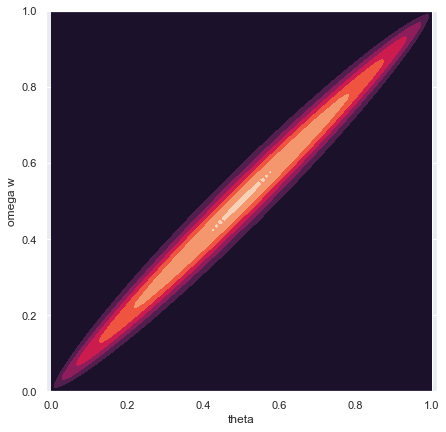

In [12]:
# contour plot of the prior distribution
X, Y = np.meshgrid(grid, grid)
plt.figure(figsize=(7,7))
plt.contourf(X, Y, pdf_tw)
plt.ylabel('omega w')
plt.xlabel('theta')
plt.axis('equal');

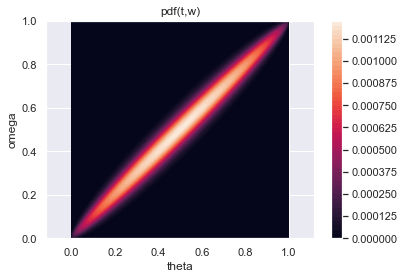

In [13]:
def show3df(Z, title=''):
    plt.contourf(X, Y, Z, 50)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.xlabel('theta')
    plt.ylabel('omega')
    plt.axis('equal');
#
show3df(pdf_tw, title='pdf(t,w)')

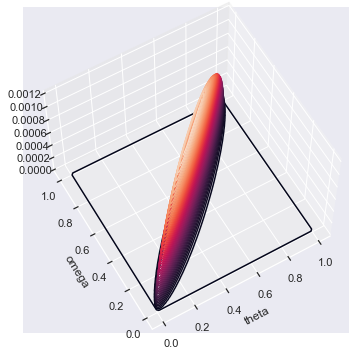

In [14]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, pdf_tw, 50)
ax.set_xlabel('theta')
ax.set_ylabel('omega')
ax.view_init(elev=60, azim=-120)

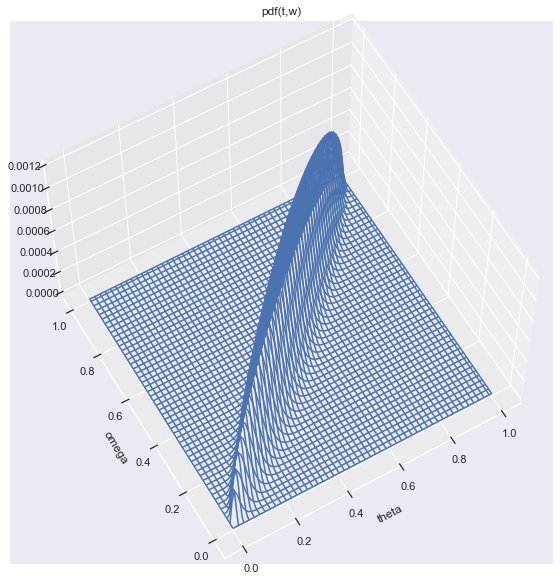

In [15]:
def wf3d(Z, title='', elev=60, azim=-120, fs=10):  # wireframe
    fig = plt.figure(figsize=(fs,fs))
    ax = plt.axes(projection='3d')
    ax.set_title(title if title is not None else 'wireframe')
    ax.plot_wireframe(X, Y, Z)
    ax.set_xlabel('theta')
    ax.set_ylabel('omega')
    ax.view_init(elev=elev, azim=azim)
#
wf3d(pdf_tw, title='pdf(t,w)')

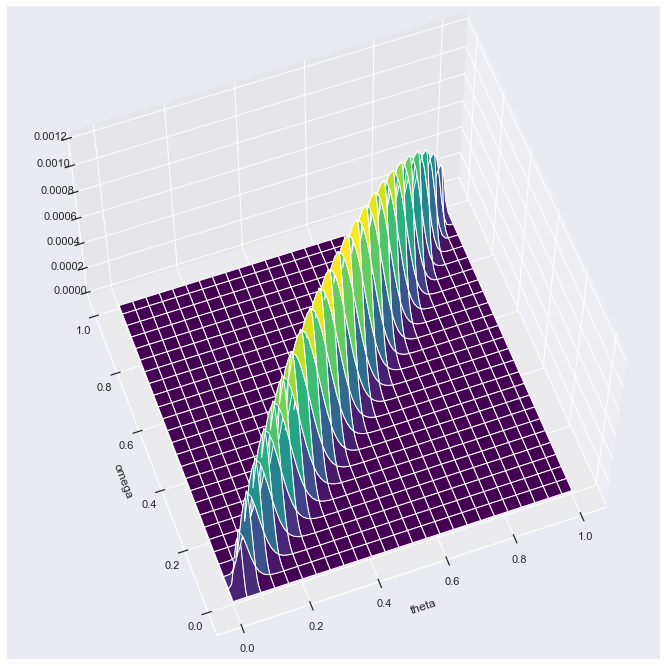

In [16]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, pdf_tw, 
                rstride=4, cstride=4,
                cmap='viridis')
ax.set_xlabel('theta')
ax.set_ylabel('omega')
ax.view_init(elev=60, azim=-110)

#### Likelihood

- Prior: 
    $$
        w \sim Beta(Aw, Bw) \\
        K = 100 \\
        p(\theta, \omega) = Beta(\theta|a(\omega), b(\omega)) Beta(\omega|A_\omega, B_\omega)
    $$
    - Domain of beta() is approximated with grid
- Likelihood:
    $$
        y_i \sim Bernoulli(\theta) \\
        p(y_i | \theta) = \theta^{y_i} (1 - \theta)^{1-y_i}
    $$
- Posterior:
    $$
        p(\theta, \omega| Y) \approx  p(\theta|a, b) p(\omega|A_w, B_w) \prod_{i=1}^n p(y_i|\theta) \\
        = p(\theta, \omega) \prod_{i=1}^n p(y_i|\theta) 
    $$

In [17]:
print(f'y = {y}')
# pmf_y_given_t = 
pdf_y_given_t = np.empty_like(prior)
for i, w in enumerate(pdf_w):
    pdf_t_at_w = pdf_t_given_w[i]
    for j, (t,pt) in enumerate(zip(grid, pdf_t_at_w)):
        p_yi = 1
        for yi in y:
            p_yi *= t if yi else 1-t
        pdf_y_given_t[i][j] = p_yi
    pdf_y_given_t[i] /= pdf_y_given_t[i].sum()
#
likelihood = pdf_y_given_t

y = [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]


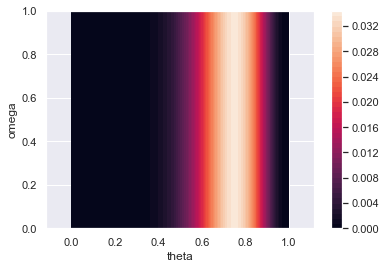

In [18]:
show3df(pdf_y_given_t)

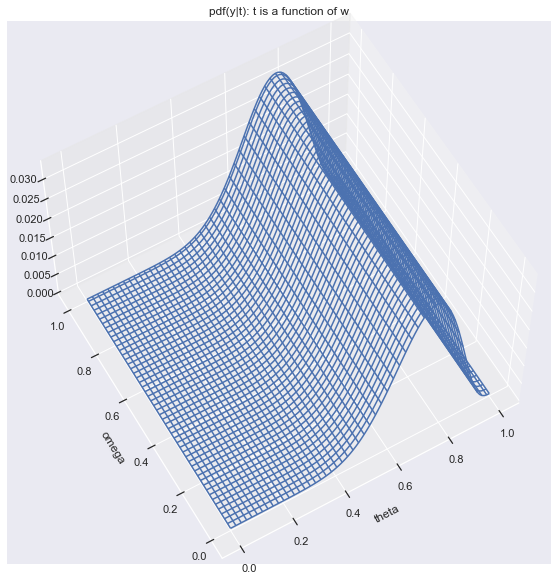

In [19]:
wf3d(pdf_y_given_t, title='pdf(y|t): t is a function of w')

#### Posterior

In [20]:
posterior = prior * likelihood
posterior /= posterior.sum()

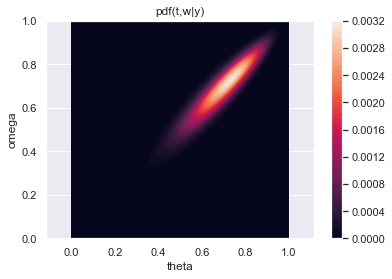

In [21]:
show3df(posterior, title='pdf(t,w|y)')

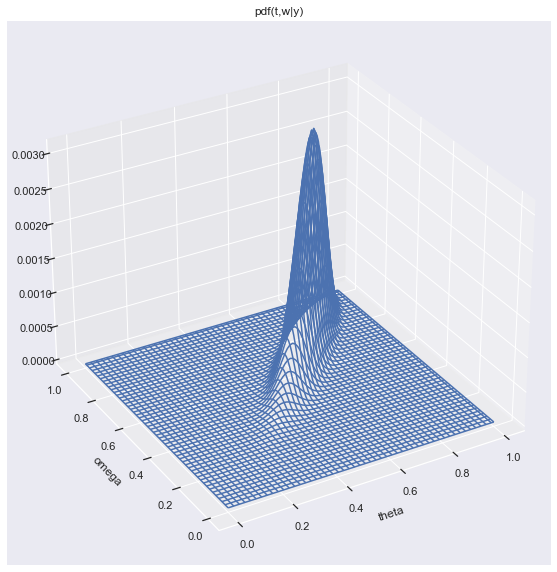

In [22]:
wf3d(posterior, title='pdf(t,w|y)', elev=30)

#### Marginal Posteriors

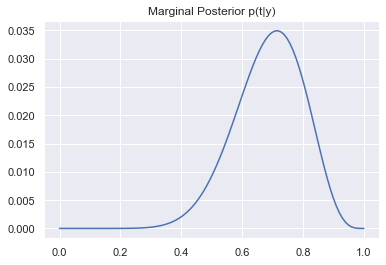

In [23]:
post_t = posterior.sum(axis=0)
plt.plot(grid, post_t)
plt.title('Marginal Posterior p(t|y)');

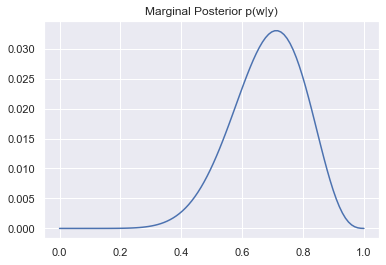

In [24]:
post_w = posterior.sum(axis=1)
plt.plot(grid, post_w)
plt.title('Marginal Posterior p(w|y)');

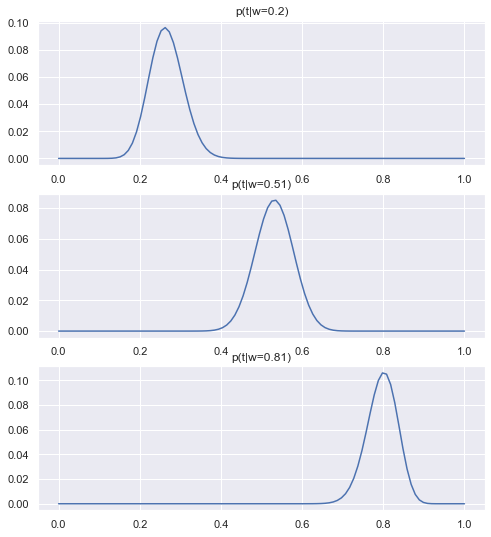

In [25]:
# posteriors, conditional at w=w0

iw0s = [20, 50, 80]
fig, axes = plt.subplots(len(iw0s), 1, figsize=(8, 3*len(iw0s)))
for iw, ax in zip(iw0s, axes.ravel()):
    p_t = posterior[iw]; p_t = p_t / p_t.sum()
    ax.plot(grid, p_t)
    ax.set_title(f'p(t|w={grid[iw]:.2})')
    pass

### Posterior by pyro MCMC

In [26]:
# convenience function
def gomcmc(model, data, num_samples=4000):
    """
    data: dict() type for model function
    """
    mcmc = MCMC(NUTS(model), num_samples=num_samples, warmup_steps=1000)
    tt_data = {k: torch.tensor(v, dtype=torch.float) for k, v in data.items()}
    mcmc.run(**tt_data)
    return mcmc

In [27]:
def model(y=None):
    w = pyro.sample('w', dist.Beta(Aw, Bw))
    a, b = w*(K-2)+1, (1-w)*(K-2)+1  # (a,b) is determined at (w, K) 
    t = pyro.sample('t', dist.Beta(a, b))
    with pyro.plate('iid_obs', len(y)):
        y = pyro.sample('y', dist.Bernoulli(probs=t), obs=y)
#
data = dict(y=y)
mcmc = gomcmc(model, data, num_samples=4000)
mcmc.summary()

Sample: 100%|███████████████████████████████████████| 5000/5000 [00:57, 86.73it/s, step size=2.83e-01, acc. prob=0.919]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         w      0.68      0.12      0.69      0.49      0.87    687.44      1.00
         t      0.68      0.11      0.69      0.51      0.87    680.38      1.00

Number of divergences: 0


In [28]:
mcmc.get_samples()['t'].shape

torch.Size([4000])

In [29]:
trace = az.from_pyro(mcmc)

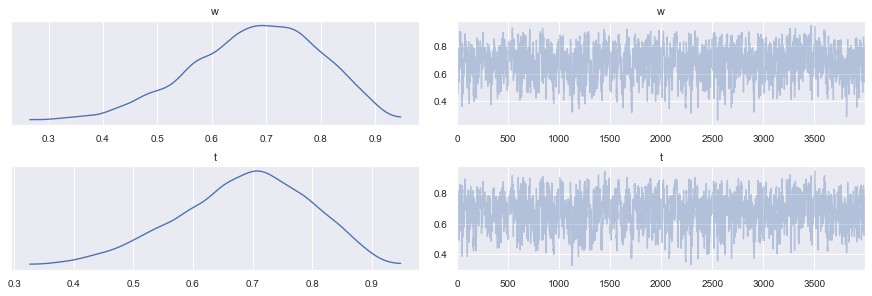

In [30]:
az.plot_trace(trace);

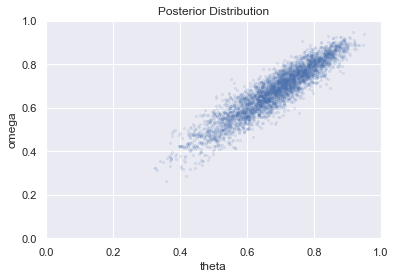

In [34]:
plt.scatter(trace.posterior['t'], trace.posterior['w'], alpha=.1, s=5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Posterior Distribution')
plt.xlabel('theta')
plt.ylabel('omega');

### Posterior via pymc3 with MCMC 
- pymc3 does not work wll in Windows 10
- try anaconda if you like

#### Exercise
- Perform expreiments for $K=6$, $A_\omega=20$, $B_\omega=20$.
- Describe how the assumption is different and how the result is different.

## Chapter 9.2 Multiple Coins from a Single Mint

- If there are S subjects altogether, then there are S+1 parameters ($t_1, ..., t_S$ and $\omega$) being estimated simultaneously.
- If our primary research interest is the overall effet of the tdrug, not the reactions of individual subjects, then we are most interested in the estimate of $\omega$.

### Posterior via grid approximation

- Suppose we have only two subjects in the same condition (i.e. two coins from the same mint).
- We want to estimate the biases $t_1$ and $t_2$ of the two subjects, and simultaneously estimate $\omega$ of the drug that influenced them.

### A realistic model with MCMC

#### Gamma Distribution
- Two parameters: shape $s$ and rate $r$
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
- https://en.wikipedia.org/wiki/Gamma_distribution

In [29]:
shapes = [0.01, 0.1, 1, 1.5, 2.5, 10]
rates = [0.01, 0.02, 0.1, 0.2, 1]

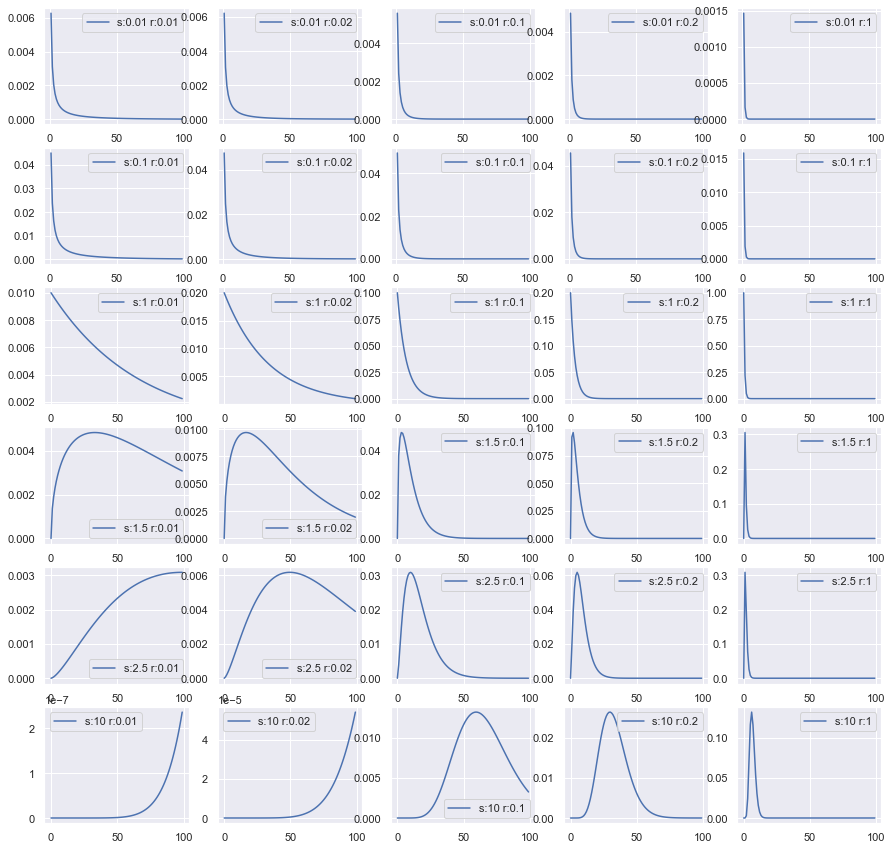

In [30]:
fig, axes = plt.subplots(len(shapes), len(rates), figsize=(15,15))
for i, shape in enumerate(shapes):
    for j, rate in enumerate(rates):
        ax = axes[i, j]
        scale = 1/rate  #
        g = stats.gamma(a=shape, scale=scale)
        x = np.linspace(0, 150, 100)
        ax.plot(g.pdf(x), label=f's:{shape} r:{rate}')
        ax.legend()

- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
    - [Shrinkage](#Shrinkage)
- [9.5.1 - Example: Baseball batting abilities by position (subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

### 9.2.4 - Example: Therapeutic touch

In [32]:
df = pd.read_csv('../data/TherapeuticTouchData.csv', dtype={'s':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   y       280 non-null    int64   
 1   s       280 non-null    category
dtypes: category(1), int64(1)
memory usage: 2.8 KB


In [33]:
df.head()

,y,s
0,1,S01
1,0,S01
2,0,S01
3,0,S01
4,0,S01


#### Figure 9.9

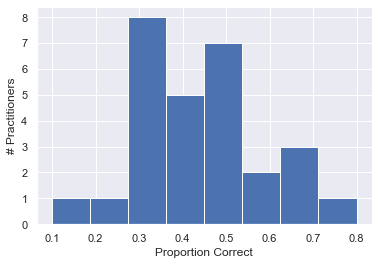

In [34]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = df_proportions.plot(kind='hist', bins=8)
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners');

#### Model (Kruschke, 2015)

In [37]:
Image('images/fig9_7.png', width=200)

NameError: name 'Image' is not defined

In [144]:
# convenience function
def gomcmc2(model, data, num_samples=4000):
    """
    data: dict() type for model function
    """
    mcmc = MCMC(NUTS(model), num_samples=num_samples, warmup_steps=1000, )
    mcmc.run(**data, )
    mcmc.summary()
    return mcmc

In [145]:
def hierarchical_model(n_theta, theta_inds, y=None):
    """
    ntheta == the number of independent objects
    dim(theta_ids) == dim(y)
    """
    omega = pyro.sample('omega', dist.Beta(1,1))
    kap_m2 = pyro.sample('kap_m2', dist.Gamma(0.01, 0.01))
    kappa = kap_m2 + 2
        
    alpha = omega*(kappa-2)+1
    beta = (1-omega)*(kappa-2)+1
    with pyro.plate('theta_plate', n_theta):
        theta = pyro.sample('theta', dist.Beta(alpha, beta))

    theta = theta[theta_inds]  # practitioner_idx
    
    with pyro.plate('observation', len(theta_inds)):
        y = pyro.sample('y', dist.Bernoulli(probs=theta), obs=y)
        
    return y
#

In [146]:
practitioner_idx = df.s.cat.codes.values
practitioner_codes = df.s.cat.categories
n_practitioners = practitioner_codes.size

data = dict(n_theta=n_practitioners, 
            theta_inds=torch.LongTensor(practitioner_idx), 
            y=torch.FloatTensor(df.y.values))

In [147]:
mcmc = gomcmc2(hierarchical_model, data, num_samples=1001)

Sample: 100%|███████████████████████████████████████| 2001/2001 [01:27, 22.80it/s, step size=2.07e-01, acc. prob=0.924]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     omega      0.44      0.04      0.44      0.38      0.50    301.65      1.00
    kap_m2     52.81     54.87     35.78      1.44    117.40     61.25      1.01
  theta[0]      0.36      0.09      0.37      0.23      0.52    266.39      1.00
  theta[1]      0.39      0.08      0.39      0.26      0.52    333.17      1.00
  theta[2]      0.41      0.08      0.41      0.27      0.54    641.33      1.00
  theta[3]      0.41      0.08      0.41      0.27      0.53    615.35      1.00
  theta[4]      0.40      0.08      0.41      0.28      0.54    751.65      1.00
  theta[5]      0.40      0.08      0.41      0.28      0.54    476.43      1.00
  theta[6]      0.41      0.08      0.42      0.26      0.53    657.33      1.00
  theta[7]      0.41      0.08      0.41      0.26      0.53    635.08      1.00
  theta[8]      0.41      0.08      0.41      0.27      0.55    606.39      1.00
  theta[9]      0.41      0

In [182]:
trace = az.from_pyro (mcmc)
trace

c:\users\vip\appdata\local\programs\python\python37\lib\site-packages\arviz\data\io_pyro.py:154: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

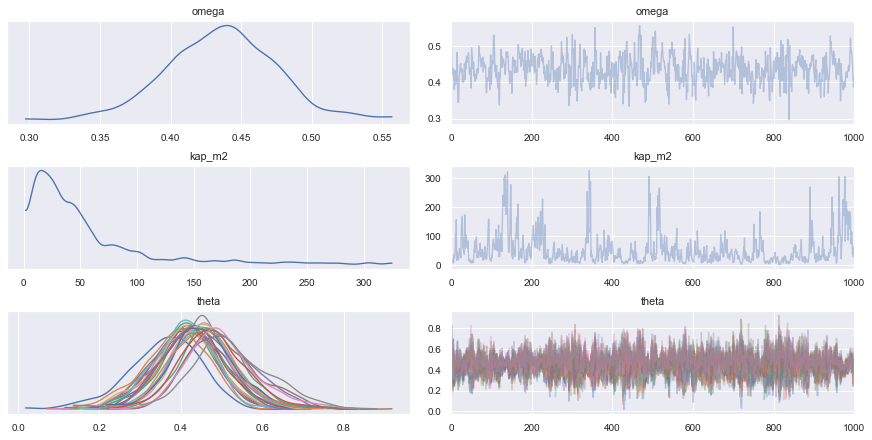

In [183]:
az.plot_trace(trace);

In [184]:
predictive = Predictive(hierarchical_model, posterior_samples=samples, num_samples=1000)
ppsamples = predictive(n_theta=n_practitioners, theta_inds=torch.LongTensor(practitioner_idx))
ppsamples.keys(), ppsamples['y'].shape

C:\Users\VIP\AppData\Roaming\Python\Python37\site-packages\pyro\infer\predictive.py:150: UserWarning: Sample's leading dimension size 1001 is different from the provided 1000 num_samples argument. Defaulting to 1001.
  .format(batch_size, num_samples, batch_size), UserWarning)


(dict_keys(['y']), torch.Size([1001, 280]))

#### Figure 9.10 - Marginal posterior distributions

KeyError: 'kappa'

Warmup:   2%|▋                                        | 84/5000 [13:10,  9.41s/it, step size=4.20e-02, acc. prob=0.775]


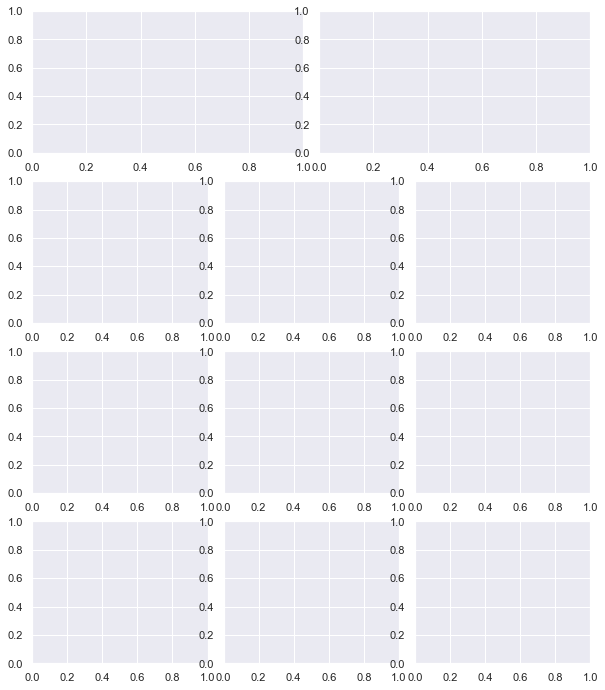

In [93]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

# thetas and theta pairs to plot
thetas = (0, 13, 27)
theta_pairs = ((0,13),(0,27),(13,27))

font_d = {'size':14}

# kappa & omega posterior plots
for var, ax in zip(['kappa', 'omega'], [ax1, ax2]):
    az.plot_posterior(trace[var], point_estimate='mode', ax=ax, color=color, round_to=2)
    ax.set_xlabel('$\{}$'.format(var), fontdict={'size':20, 'weight':'bold'})
ax1.set(xlim=(0,500))

# theta posterior plots
for var, ax in zip(thetas,[ax3, ax7, ax11]):
    pm.plot_posterior(trace['theta'][:,var], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}]'.format(var), fontdict=font_d)

# theta scatter plots
for var, ax in zip(theta_pairs,[ax6, ax9, ax10]):
    ax.scatter(trace['theta'][::10,var[0]], trace['theta'][::10,var[1]], alpha=0.75, color=color, facecolor='none')
    ax.plot([0, 1], [0, 1], ':k', transform=ax.transAxes, alpha=0.5)
    ax.set_xlabel('theta[{}]'.format(var[0]), fontdict=font_d)
    ax.set_ylabel('theta[{}]'.format(var[1]), fontdict=font_d)
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal')

# theta posterior differences plots
for var, ax in zip(theta_pairs,[ax4, ax5, ax8]):
    pm.plot_posterior(trace['theta'][:,var[0]]-trace['theta'][:,var[1]], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}] - theta[{}]'.format(*var), fontdict=font_d)

plt.tight_layout()

### Shrinkage

Let's create a model with just the theta estimations per practitioner, without the influence of a higher level distribution. Then we can compare the theta values with the hierarchical model above.

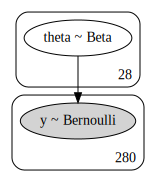

In [12]:
with pm.Model() as unpooled_model:
    
    theta = pm.Beta('theta', 1, 1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', theta[practitioner_idx], observed=df.y)
    
pm.model_to_graphviz(unpooled_model)

In [13]:
with unpooled_model:
    unpooled_trace = pm.sample(5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:07<00:00, 3095.91draws/s]


Here we concatenate the trace results (thetas) from both models into a dataframe. Next we shape the data into a format that we can use with Seaborn's pointplot.

In [14]:
df_shrinkage = (pd.concat([pm.summary(unpooled_trace).iloc[:,0],
                           pm.summary(trace).iloc[3:,0]],
                          axis=1)
                .reset_index())
df_shrinkage.columns = ['theta', 'unpooled', 'hierarchical']
df_shrinkage = pd.melt(df_shrinkage, 'theta', ['unpooled', 'hierarchical'], var_name='Model')
df_shrinkage.head()

,theta,Model,value
0,theta__0,unpooled,0.166819
1,theta__1,unpooled,0.249644
2,theta__2,unpooled,0.334258
3,theta__3,unpooled,0.333547
4,theta__4,unpooled,0.333647


The below plot shows that the theta estimates on practitioner level are pulled towards the group mean of the hierarchical model.

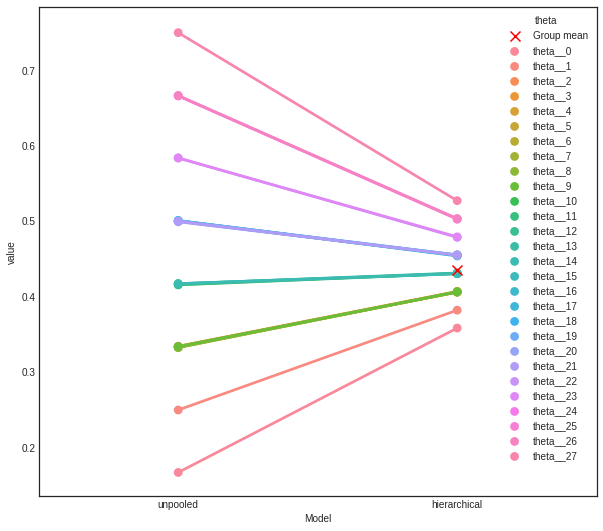

In [15]:
plt.figure(figsize=(10,9))
plt.scatter(1, pm.summary(trace).iloc[0,0], s=100, c='r', marker='x', zorder=999, label='Group mean')
sns.pointplot(x='Model', y='value', hue='theta', data=df_shrinkage);

### 9.5.1 - Example: Baseball batting abilities by position

In [16]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
Player    948 non-null object
PriPos    948 non-null category
Hits      948 non-null int64
AtBats    948 non-null int64
dtypes: category(1), int64(2), object(1)
memory usage: 23.6+ KB


The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [17]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186
5,Nathan Adcock,Pitcher,0,1,0.000000
6,Jeremy Affeldt,Pitcher,0,1,0.000000
7,Brandon Allen,1st Base,2,20,0.100000
8,Yonder Alonso,1st Base,150,549,0.273224
9,Jose Altuve,2nd Base,167,576,0.289931


In [18]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')['Hits','AtBats'].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

#### Model (Kruschke, 2015)

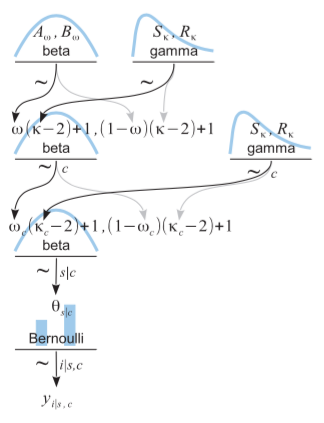

In [19]:
Image('images/fig9_13.png', width=300)

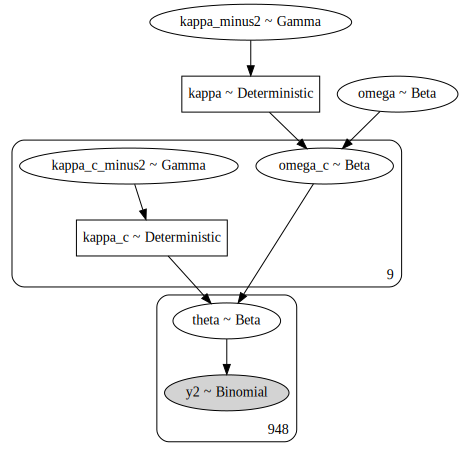

In [20]:
pripos_idx = df2.PriPos.cat.codes.values
pripos_codes = df2.PriPos.cat.categories
n_pripos = pripos_codes.size

# df2 contains one entry per player
n_players = df2.index.size

with pm.Model() as hierarchical_model2:
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Primary field positions)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_pripos)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
        
    # Parameter for individual players
    theta = pm.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1,
                    (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y2 = pm.Binomial('y2', n=df2.AtBats.values, p=theta, observed=df2.Hits)

pm.model_to_graphviz(hierarchical_model2)

In [21]:
with hierarchical_model2:
    trace2 = pm.sample(3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus2, omega_c, kappa_minus2, omega]
Sampling 4 chains: 100%|██████████| 14000/14000 [02:56<00:00, 12.43draws/s] 
The number of effective samples is smaller than 10% for some parameters.


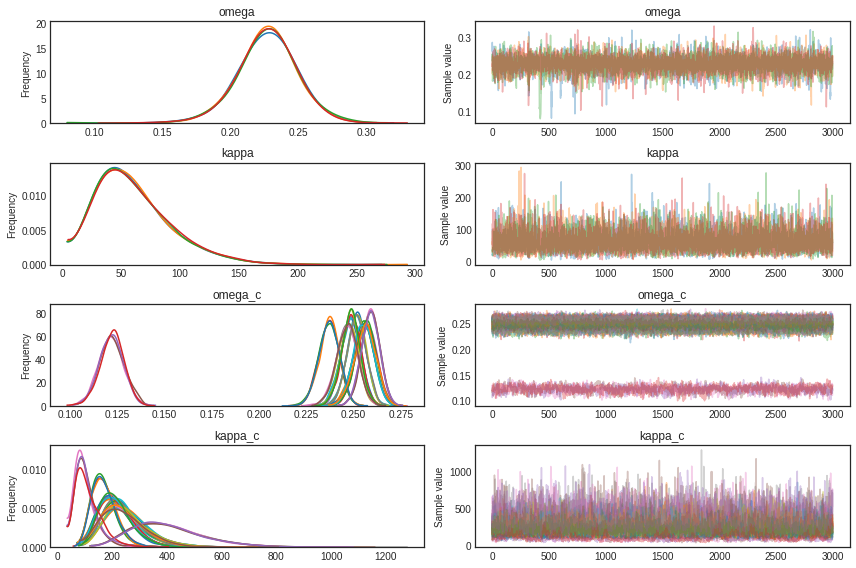

In [22]:
pm.traceplot(trace2, ['omega', 'kappa', 'omega_c', 'kappa_c']);

#### Figure 9.17

#### Posterior distribution of hyper parameter omega after sampling.

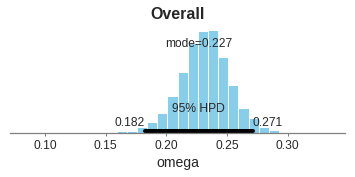

In [23]:
pm.plot_posterior(trace2['omega'], point_estimate='mode', color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14});

#### Posterior distributions of the omega_c parameters after sampling.

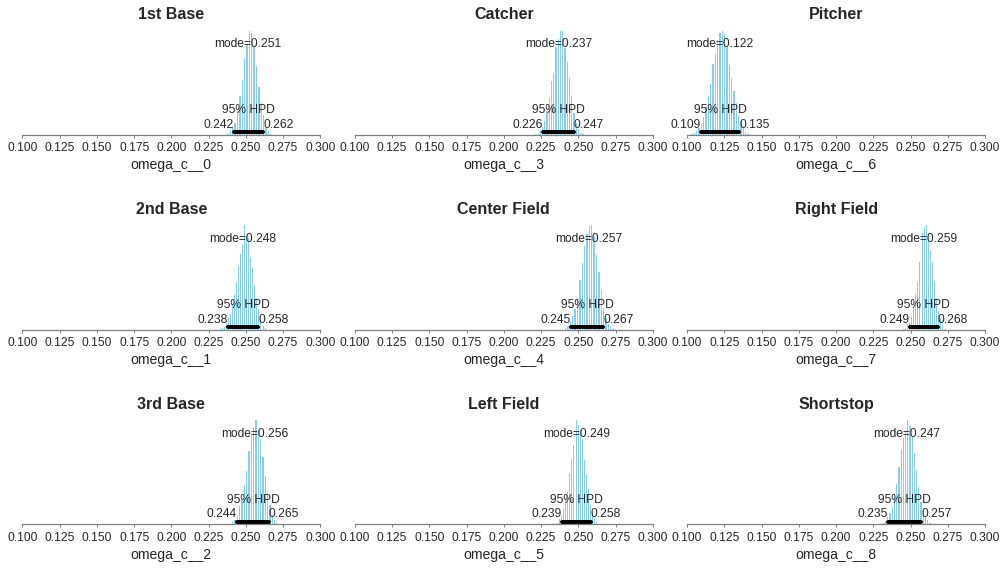

In [24]:
fig, axes = plt.subplots(3,3, figsize=(14,8))

for i, ax in enumerate(axes.T.flatten()):
    pm.plot_posterior(trace2['omega_c'][:,i], ax=ax, point_estimate='mode', color=color)
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.10,0.30)

plt.tight_layout(h_pad=3)